# Финальное задание. Игра Dota 2

## Подготовка данных

Проведем загрузку данных и преварительную обработку:

    1.уберем из выборки признаки, которые "заглядывают в будущее";
    2.отделим целевую переменную (radiant_win) от признаков;

In [2]:
import pandas as pd
import numpy as np
import sklearn

In [3]:
features = pd.read_csv('E:\\BOBA\\edu\\Coursera Machine Learning\\Final project\\features.csv', index_col='match_id')
x = features.drop(["radiant_win", "duration", "tower_status_radiant", "tower_status_dire", "barracks_status_radiant", 
                    "barracks_status_dire"], 1)
y = features[["radiant_win"]]

    3.Проверим есть ли в выборки пропуски (список признаков с пропусками ниже) и заменим их нулями.

In [4]:
x.isnull().sum()[x.isnull().sum()>0]

first_blood_time               19553
first_blood_team               19553
first_blood_player1            19553
first_blood_player2            43987
radiant_bottle_time            15691
radiant_courier_time             692
radiant_flying_courier_time    27479
radiant_first_ward_time         1836
dire_bottle_time               16143
dire_courier_time                676
dire_flying_courier_time       26098
dire_first_ward_time            1826
dtype: int64

Пропуски в полях "first_blood_..." вероятно означает, что в игре в течение первых пяти минут не наступило событие "Первая кровь".

In [7]:
x.fillna(0, inplace=True)

## Градиентный бустинг 

Попробуем спрогнозировать результат матча с помощью градиентного бустинга. Рассмотрим несколько значений параметров модели, а именно: параметра 'learning rate' и параметра, регулирующего количество деревьев в ансамбле. Проведем NxK кросс-валидацию по пяти блокам для оценки качества каждой модели. Критерий качества - площадь под ROC-кривой. На графике ниже приведены результаты оценки моделей.

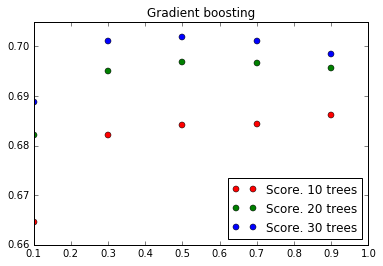

In [156]:
import sklearn.ensemble
param_grid = dict(learning_rate = np.arange(0.1, 1, 0.2), n_estimators = [10, 20, 30])
learner = sklearn.ensemble.GradientBoostingClassifier(random_state=123)
validator = sklearn.cross_validation.KFold(len(y), n_folds=5, shuffle=True, random_state=123)
gs = sklearn.grid_search.GridSearchCV(learner, param_grid = param_grid, scoring='roc_auc', cv=validator)
gs.fit(x, np.ravel(y))
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure()
plt.plot(param_grid['learning_rate'], zip(*filter(lambda x: x[0]['n_estimators'] == 10, gs.grid_scores_))[1], 'ro')
plt.plot(param_grid['learning_rate'], zip(*filter(lambda x: x[0]['n_estimators'] == 20, gs.grid_scores_))[1], 'go')
plt.plot(param_grid['learning_rate'], zip(*filter(lambda x: x[0]['n_estimators'] == 30, gs.grid_scores_))[1], 'bo')
plt.legend(['Score. 10 trees','Score. 20 trees','Score. 30 trees'], loc = 'best')
plt.title('Gradient boosting')

Видно, что во всех случаях лучшее качество показали модели с 30 деревьями. Наилучшее качество показала модель с параметром learning_rate равным 0.5. Используем эту модель для оценки времени кросс-валидации.

In [188]:
import time
import datetime
learner = sklearn.ensemble.GradientBoostingClassifier(n_estimators=30, random_state=123, learning_rate=0.5)
start_time = datetime.datetime.now()
score = np.mean(sklearn.cross_validation.cross_val_score(learner, x, np.ravel(y), cv=validator, scoring="roc_auc"))
print 'Score is', score, '. Validation took', (datetime.datetime.now() - start_time).total_seconds(), 'sec'

Score is 0.701862546699 . Validation took 221.036 sec


Кросс-валидация заняла практически 4 минуты.

Качество прогнозирования удовлетворительное, хотя автор уверен, что его можно улучшить за счет увеличения количества деревьев в ансамбле, более точной настроки параметра learning_rate и глубины деревьев (по умолчанию 3). Во всяком случае имеет смысл увеличивать количество деревьев в бустинге, скорее всего в этой задаче (как и во многих других) разумно большое количество деревьев не приведет к переобучению. Однако при увеличении количества деревьев выростит и время обучения ансамбля. Автор считает, что лучшим способом ускорения обучения было бы использование "хорошего" метода оптимизации параметров (не жадного, для глобальной оптимизации, с элементами рандомизации). Такой подход скорее всего приведет к меньшему количеству циклов обучения при лучшем качестве на выходе. Хотя можно конечно ещё сокращать объем выборки на обучении, например с помощью параметра subsample. Также может оказаться, что при большем количестве деревьев оптимальным будет выбор деревьев меньшей глубины (например 2), что тоже ускорит процесс обучения. Впрочем, ни один из этих подходов не противоречит друг другу и их можно использовать совместно.

## Логистическая регрессия

Теперь попробуем предсказать итог матча с помощью логистической регрессии. Т.к. выбранный нами метод чувствительный к масштабу данных, будем стандартизировать данные. Для борьбы с эффектом мульколлинеарности воспользуемся l2-регуляризацией. Проведем перебор значений параметра регуляризатора для нахождения наилучшего с точки зрения критерия качества на кросс-валидации по пяти блокам. Критерий качества, по прежнему, площадь под ROC-кривой.

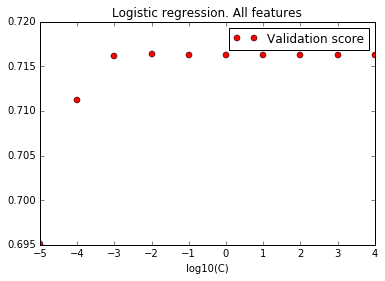

In [190]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
xs = scaler.fit_transform(x)

param_grid = dict(C = np.power(10.0, np.arange(-5, 5)))
learner = sklearn.linear_model.LogisticRegression(random_state=123)
validator = sklearn.cross_validation.KFold(len(y), n_folds=5, shuffle=True, random_state=123)
gs = sklearn.grid_search.GridSearchCV(learner, param_grid = param_grid, scoring='roc_auc', cv=validator)
gs.fit(xs, np.ravel(y))
plt.figure()
plt.plot(np.log10(param_grid['C']), zip(*gs.grid_scores_)[1], 'ro')
plt.legend(['Validation score'], loc = 'best')
plt.title('Logistic regression. All features')
plt.xlabel('log10(C)')

Наибольшая площадь под ROC-кривой достигается при значении C равном 10^-2. Используем эту модель для оценки времени кросс-валидации.

In [193]:
learner = sklearn.linear_model.LogisticRegression(C = 10**-2, random_state=123)
start_time = datetime.datetime.now()
score = np.mean(sklearn.cross_validation.cross_val_score(learner, xs, np.ravel(y), cv=validator, scoring="roc_auc"))
print 'Score is', score, '. Validation took', (datetime.datetime.now() - start_time).total_seconds(), 'sec'

Score is 0.716343021043 . Validation took 19.18 sec


Кросс-валидация заняла 19 секунд. При этом качество и скорость логистической регрессии оказывается лучше, чем в градиентном бустинге. В первую очередь, автор объясняет это довольно грубым подходом к оптимизации параметров алгоритмов. Вероятнее всего, набор параметров градиентного бустинга далек от оптимального, впрочем может быть так, что данная конретная задача действительно лучше решается логистической регрессией и парадигма этого способа моделирования лучше подходит под условия задачи.

Уберем из выборки категорийные переменные, отражающие тип комнаты, а также типы героев, выбранных игроками обеих команд. Заменим пропуски в данных нулями и проведем стандартизацию признаков.

In [160]:
x_num = features.drop(["radiant_win", "duration", "tower_status_radiant", "tower_status_dire", "barracks_status_radiant", 
                        "barracks_status_dire", "lobby_type", 
                        "r1_hero", "r2_hero", "r3_hero", "r4_hero", "r5_hero",
                        "d1_hero", "d2_hero", "d3_hero", "d4_hero", "d5_hero"], 1)
x_num.fillna(0, inplace=True)
x_nums = scaler.fit_transform(x_num)

Обучим классификатор на новой выборке, аналогично предыдущему обучению.

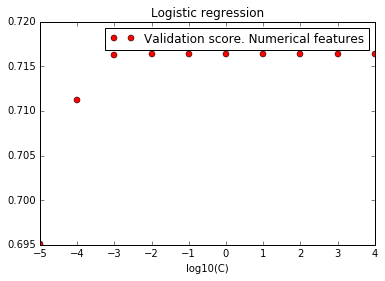

In [194]:
param_grid = dict(C = np.power(10.0, np.arange(-5, 5)))
learner = sklearn.linear_model.LogisticRegression(random_state=123)
validator = sklearn.cross_validation.KFold(len(y), n_folds=5, shuffle=True, random_state=123)
gs = sklearn.grid_search.GridSearchCV(learner, param_grid = param_grid, scoring='roc_auc', cv=validator)
gs.fit(x_nums, np.ravel(y))
plt.figure()
plt.plot(np.log10(param_grid['C']), zip(*gs.grid_scores_)[1], 'ro')
plt.legend(['Validation score. Numerical features'], loc = 'best')
plt.title('Logistic regression')
plt.xlabel('log10(C)')

Наилучшее качество показала модель с параметром C равным 10^-2. Посмотрим изменилось ли качество при удалении категорийных признаков. 

In [201]:
learner = sklearn.linear_model.LogisticRegression(C = 10**-2, random_state=123)
start_time = datetime.datetime.now()
score = np.mean(sklearn.cross_validation.cross_val_score(learner, x_nums, np.ravel(y), cv=validator, scoring="roc_auc"))
print 'Score is', score, '. Validation took', (datetime.datetime.now() - start_time).total_seconds(), 'sec'

Score is 0.716402476136 . Validation took 18.985 sec


Качество незначительно улучшилось. Автор считает, что такое изменение качества модели связано с изменением блоков на кросс-валидации. Изменение матрицы "объект-признак" привело к формированию других блоков, что в свою очередь привело к незначительному изменению итоговой оценки алгоритма.



Попробуем воспользоваться информацией о типах героев (ведь это довольно ценная информация). Закодируем признак принадлежности командам героев определенного типа с помощью "мешка слов". Посчитаем количество уникальных типов героев и приведем их идентификаторы.

In [162]:
hero_ids = np.unique(pd.concat([features.r1_hero, features.r2_hero, features.r3_hero, features.r4_hero, features.r5_hero, 
           features.d1_hero, features.d2_hero, features.d3_hero, features.d4_hero, features.d5_hero]))
print 'There are', len(hero_ids), 'unique IDs of heroes. \nIDs:\n', hero_ids

There are 108 unique IDs of heroes. 
IDs:
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 109 110 112]


Закодируем признак принадлежности героя к команде. Добавим полученные признаки к набору признаков, из которго мы заранее исключили категорийные признаки и проведем стандартизацию новой матрицы "объект-признак".

In [163]:
X_pick = np.zeros((x_num.shape[0], 112))

for i, match_id in enumerate(features.index):
    for p in xrange(5):
        X_pick[i, features.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pick[i, features.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1

In [164]:
x_num2 = pd.DataFrame(np.concatenate([x_num, pd.DataFrame(X_pick)], axis=1))
x_num2s = scaler.fit_transform(x_num2)

Обучим логистическую регрессию по старой схеме. На графике оценка площади под ROC-кривой в зависимости от значения параметра l2-регуляризатора.

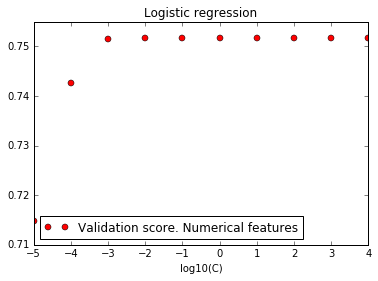

In [198]:
param_grid = dict(C = np.power(10.0, np.arange(-5, 5)))
learner = sklearn.linear_model.LogisticRegression(random_state=123)
validator = sklearn.cross_validation.KFold(len(y), n_folds=5, shuffle=True, random_state=123)
gs = sklearn.grid_search.GridSearchCV(learner, param_grid = param_grid, scoring='roc_auc', cv=validator)
gs.fit(x_num2s, np.ravel(y))
plt.figure()
plt.plot(np.log10(param_grid['C']), zip(*gs.grid_scores_)[1], 'ro')
plt.legend(['Validation score. Numerical features'], loc = 'best')
plt.title('Logistic regression')
plt.xlabel('log10(C)')

И опять лучшим значением параметра C стало значение 10^-2. Измерим значение метрики и время кросс-валидации полученной модели.

In [202]:
learner = sklearn.linear_model.LogisticRegression(C = 10**-2, random_state=123)
start_time = datetime.datetime.now()
score = np.mean(sklearn.cross_validation.cross_val_score(learner, x_num2s, np.ravel(y), cv=validator, scoring="roc_auc"))
print 'Score is', score, '. Validation took', (datetime.datetime.now() - start_time).total_seconds(), 'sec'

Score is 0.751775517691 . Validation took 37.128 sec


Теперь качество выросло довольно сильно. Значит информация о типах героев действительно является ценной и вносит значимый вклад в итог игры.

Лучшей из исследованных моделей оказалась логистическая регрессия c обнуленными значениями пропусков, с использованием "мешка слов" для кодирования признаков принадлежности типов героев к командам, с l2-регуляризацией с параметром C = 10^-2 построенная на стандартизированных данных. Используем эту модель для предсказания итога игры на тестовых данных.

In [203]:
featuresT = pd.read_csv('E:\\BOBA\\edu\\Coursera Machine Learning\\Final project\\features_test.csv', index_col='match_id')
x_numT = featuresT.drop(["lobby_type", 
                        "r1_hero", "r2_hero", "r3_hero", "r4_hero", "r5_hero",
                        "d1_hero", "d2_hero", "d3_hero", "d4_hero", "d5_hero"], 1)
x_numT.fillna(0, inplace=True)

X_pickT = np.zeros((x_numT.shape[0], 112))

for i, match_id in enumerate(featuresT.index):
    for p in xrange(5):
        X_pickT[i, featuresT.ix[match_id, 'r%d_hero' % (p+1)]-1] = 1
        X_pickT[i, featuresT.ix[match_id, 'd%d_hero' % (p+1)]-1] = -1
x_num2T = pd.DataFrame(np.concatenate([x_numT, pd.DataFrame(X_pickT)], axis=1))
x_num2Ts = scaler.fit_transform(x_num2T)

In [204]:
learner = sklearn.linear_model.LogisticRegression(C = 10**-2, random_state=123)
learner.fit(x_num2s, np.ravel(y))
pred = learner.predict_proba(x_num2Ts)[:,1]

Убедимся в том, что предсказания адекватные: лежат в промежутке [0, 1], а также не повторяют (ну или почти никогда не повторяются). Рассчитаем минимальное, максимальное значения прогнозов, подсчитаем количество прогнозов и количество уникальных прогнозов для тестовых данных.

In [205]:
max(pred), min(pred), len(pred), len(np.unique(pred))

(0.99632871592542938, 0.0087059007692345206, 17177, 17177)

Действительно предсказания являются адекватными.

В сухом остатке: "Machine Learning - это круто!!"
    <img src = "machine_learning_robot.jpg">
    
Спасибо за внимание!